### Load Train and Test Data   

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification, BertTokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv(
    'data/trainSet.csv',
    names=['search_term', 'category'])

In [4]:
df.head()

,search_term,category
0,yew hedge,1221
1,fire detection shop,19
2,cheap couch roll,398
3,extra watermelon gum,1108
4,used generators for sale uk,213


In [5]:
df_test = pd.read_table('data/candidateTestSet.txt', names=['search_term'])

In [6]:
df_test.head()

,search_term
0,twister picnic blanket
1,best stop smoking app
2,phosphorus fertiliser
3,tattoo books
4,child's desk chair


In [7]:
# list of unique existing categories
possible_labels = df.category.unique() 

In [8]:
TOTAL_LABELS = len(possible_labels) 
TOTAL_LABELS

1419

### Training/Validation Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    df.index.values,
    df.category.values,
    test_size=0.1,
    random_state=RANDOM_SEED,
    stratify=df.category.values
)

In [10]:
df['data_type'] = ['not_set']*df.shape[0]
df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

In [11]:
# train test split
df.groupby(['category', 'data_type']).count()

search_term
category data_type             
0        train              408
         val                 45
1        train              364
         val                 40
2        train              524
...                         ...
1416     val                 50
1417     train              469
         val                 52
1418     train              408
         val                 45

[2837 rows x 1 columns]

In [12]:
train_df = df[df.data_type=='train']
val_df = df[df.data_type=='val']

12


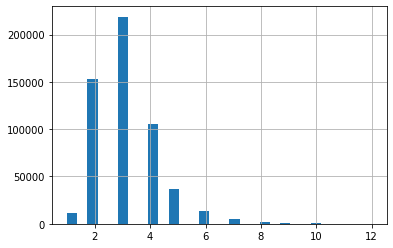

In [13]:
# search for max sequence length
seq_len = [len(i.split()) for i in train_df.search_term]
pd.Series(seq_len).hist(bins = 30)
max_length = 0
for i in seq_len:
    if i > max_length:
        max_length = i
print(max_length)

### Task 4: Loading Tokenizer and encoding our Data

In [14]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [15]:
encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=="train"].search_term.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=12,
    return_tensors="pt"
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=="val"].search_term.values,
    add_special_tokens=True,
    return_attention_mask=True,
    padding=True,
    truncation=True,
    max_length=12,
    return_tensors="pt"
)

input_ids_train = encoded_data_train["input_ids"] 
attention_masks_train = encoded_data_train["attention_mask"] 
labels_train = torch.tensor(df[df.data_type=="train"].category.values)

input_ids_val = encoded_data_val["input_ids"]
attention_masks_val = encoded_data_val["attention_mask"]
labels_val = torch.tensor(df[df.data_type=="val"].category.values)

In [16]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val, labels_val)

In [17]:
len(dataset_train)

546140

In [18]:
len(dataset_val)

60683

### Create PyTorch DataLoaders

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [20]:
BATCH_SIZE = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=BATCH_SIZE
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=BATCH_SIZE
)

### Setting up BERT Pretrained Model

In [21]:
model = BertForSequenceClassification.from_pretrained(
    PRE_TRAINED_MODEL_NAME,
    num_labels = TOTAL_LABELS,
    output_attentions=False,
    output_hidden_states=False
    )

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
# push the model to GPU
model = model.to(device)

In [23]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## Setting Up Optimizer and Scheduler

In [24]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [25]:
optimizer = AdamW(
    model.parameters(),
    lr=5e-5, 
    eps=1e-8
)

In [26]:
EPOCHS = 10
scheduler = get_linear_schedule_with_warmup( 
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*EPOCHS 
)

### Task 8: Defining our Performance Metrics

#### Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification)

In [27]:
from sklearn.metrics import f1_score

In [28]:
# we using f-1 score because we know about class imbalance.
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [29]:
def accuracy_per_class(preds, labels):
    label_acc = {} 
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        label_acc[label] = len(y_preds[y_preds==label])/len(y_true) 
    return label_acc

### Training our model

#### Approach adopted from an older version of HuggingFace's run_glue.py script. [Here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128) 

In [30]:
def train():
  
    model.train()

    total_loss = 0
  
    # iterate over batches
    for step, batch in enumerate(dataloader_train):
    
        # progress update after every 5000 batches.
        if step % 5000 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader_train)))

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        total_loss += loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
    
    # compute the training loss of the epoch
    avg_loss = total_loss / len(dataloader_train)

    #returns the loss and predictions
    return avg_loss

In [31]:
def evaluate(dataloader_val):

    model.eval()
    
    total_loss = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        total_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    avg_loss = total_loss/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return avg_loss, predictions, true_vals

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# store training and validation loss of each epoch
history = {'train_loss': {}, 'val_loss': {}}

# for each epoch
for epoch in range(EPOCHS):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, EPOCHS))
    
    # train model
    train_loss = train()
    
    # evaluate model
    valid_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'model/bert_version_2_saved_weights.pt')
    
    # training and validation loss
    history['train_loss'][epoch] = train_loss
    history['val_loss'][epoch] =  valid_loss

    print(f'\nTraining Loss:     {train_loss:.3f}')
    print(f'Validation Loss:     {valid_loss:.3f}')
    print(f'F1 Score (Weighted): {val_f1:.3f}')

In [34]:
# load weights of best model
path = 'model/bert_version_2_saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [35]:
_, predictions, true_vals = evaluate(dataloader_val)

In [36]:
accuracy = accuracy_per_class(predictions, true_vals)

In [ ]:
print('Training and validation loss per epoch: ', history)